# Advances in Financial Machine Learning
## CHAPTER 2 - Financial Data Structures
### 2.4.2 PCA Weights
#### SNIPPET 2.1 PCA WEIGHTS FROM A RISK DISTRIBUTION R
Snippet 2.1 implements this method, where the user-defined risk distribution
R is passed through argument riskDist (optional None). If riskDist is None,
the code will assume all risk must be allocated to the principal component with
smallest eigenvalue, and the weights will be the last eigenvector re-scaled to match
𝜎 (riskTarget).

In [1]:
def pcaWeights(cov,riskDist=None,riskTarget=1.):
    # Following the riskAlloc distribution, match riskTarget
    eVal,eVec=np.linalg.eigh(cov) # must be Hermitian
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    if riskDist is None:
        riskDist=np.zeros(cov.shape[0])
        riskDist[-1]=1.
    loads=riskTarget*(riskDist/eVal)**.5
    wghts=np.dot(eVec,np.reshape(loads,(-1,1)))
    #ctr=(loads/riskTarget)**2*eVal # verify riskDist
    return wghts

#### SNIPPET 2.2 FORM A GAPS SERIES, DETRACT IT FROM PRICES

In [2]:
def getRolledSeries(pathIn,key):
    series=pd.read_hdf(pathIn,key='bars/ES_10k')
    series['Time']=pd.to_datetime(series['Time'],format='%Y%m%d%H%M%S%f')
    series=series.set_index('Time')
    gaps=rollGaps(series)
    for fld in ['Close','VWAP']:series[fld]-=gaps
    return series
#———————————————————————————————————————————
def rollGaps(series,dictio={'Instrument':'FUT_CUR_GEN_TICKER','Open':'PX_OPEN', \
    'Close':'PX_LAST'},matchEnd=True):
    # Compute gaps at each roll, between previous close and next open
    rollDates=series[dictio['Instrument']].drop_duplicates(keep='first').index
    gaps=series[dictio['Close']]*0
    iloc=list(series.index)
    iloc=[iloc.index(i)-1 for i in rollDates] # index of days prior to roll
    gaps.loc[rollDates[1:]]=series[dictio['Open']].loc[rollDates[1:]]- \
    series[dictio['Close']].iloc[iloc[1:]].values
    gaps=gaps.cumsum()
    if matchEnd:gaps-=gaps.iloc[-1] # roll backward
    return gaps

#### SNIPPET 2.3 NON-NEGATIVE ROLLED PRICE SERIES

In [6]:
import pandas as pd

raw=pd.read_csv(filePath,index_col=0,parse_dates=True)
gaps=rollGaps(raw,dictio={'Instrument':'Symbol','Open':'Open','Close':'Close'})
rolled=raw.copy(deep=True)
for fld in ['Open','Close']:rolled[fld]-=gaps
rolled['Returns']=rolled['Close'].diff()/raw['Close'].shift(1)
rolled['rPrices']=(1+rolled['Returns']).cumprod()

NameError: name 'filePath' is not defined

#### SNIPPET 2.4 THE SYMMETRIC CUSUM FILTER

In [7]:
def getTEvents(gRaw,h):
    tEvents,sPos,sNeg=[],0,0
    diff=gRaw.diff()
    for i in diff.index[1:]:
        sPos,sNeg=max(0,sPos+diff.loc[i]),min(0,sNeg+diff.loc[i])
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

## CHAPTER 3 - Labeling
#### SNIPPET 3.1 DAILY VOLATILITY ESTIMATES

In [8]:
def getDailyVol(close,span0=100):
    # daily vol, reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]
    df0=pd.Series(close.index[df0–1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily returns
    df0=df0.ewm(span=span0).std()
    return df0

SyntaxError: invalid character in identifier (<ipython-input-8-1b5ff353187c>, line 5)

#### SNIPPET 3.2 TRIPLE-BARRIER LABELING METHOD

In [9]:
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0:pt=ptSl[0]*events_['trgt']
    else:pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0:sl=-ptSl[1]*events_['trgt']
    else:sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss.
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking.
    return out

#### SNIPPET 3.3 GETTING THE TIME OF FIRST TOUCH

In [10]:
def getEvents(close,tEvents,ptSl,trgt,minRet,numThreads,t1=False):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT,index=tEvents)
    #3) form events object, apply stop loss on t1
    side_=pd.Series(1.,index=trgt.index)
    events=pd.concat({'t1':t1,'trgt':trgt,'side':side_}, \
        axis=1).dropna(subset=['trgt'])
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index), \
        numThreads=numThreads,close=close,events=events,ptSl=[ptSl,ptSl])
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    events=events.drop('side',axis=1)
    return events

#### SNIPPET 3.4 ADDING A VERTICAL BARRIER

In [11]:
t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
t1=t1[t1<close.shape[0]]
t1=pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]) # NaNs at end

NameError: name 'close' is not defined

#### SNIPPET 3.5 LABELING FOR SIDE AND SIZE

In [12]:
def getBins(events,close):
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    return out

#### SNIPPET 3.6 EXPANDING getEvents TO INCORPORATE META-LABELING

In [14]:
def getEvents(close,tEvents,ptSl,trgt,minRet,numThreads,t1=False,side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT,index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index),[ptSl[0],ptSl[0]]
    else:side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=pd.concat({'t1':t1,'trgt':trgt,'side':side_}, \
        axis=1).dropna(subset=['trgt'])
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index), \
        numThreads=numThreads,close=inst['Close'],events=events,ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

#### SNIPPET 3.7 EXPANDING getBins TO INCORPORATE META-LABELING

In [16]:
def getBins(events,close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    —events.index is event's starttime
    —events[’t1’] is event's endtime
    —events[’trgt’] is event's target
    —events[’side’] (optional) implies the algo's position side
    Case 1: (’side’ not in events): bin in (-1,1) <—label by price action
    Case 2: (’side’ in events): bin in (0,1) <—label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

#### SNIPPET 3.8 DROPPING UNDER-POPULATED LABELS

In [17]:
def dropLabels(events,minPtc=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print 'dropped label',df0.argmin(),df0.min()
        events=events[events['bin']!=df0.argmin()]
    return events

SyntaxError: invalid syntax (<ipython-input-17-0a8af544e6d2>, line 6)

## CHAPTER 4 - Sample Weights
#### SNIPPET 4.1 ESTIMATING THE UNIQUENESS OF A LABEL

In [19]:
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    Any event that starts before t1[molecule].max() impacts the count.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]

#### SNIPPET 4.2 ESTIMATING THE AVERAGE UNIQUENESS OF A LABEL

In [20]:
def mpSampleTW(t1,numCoEvents,molecule):
    # Derive average uniqueness over the event's lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght
#———————————————————————————————————————
numCoEvents=mpPandasObj(mpNumCoEvents,('molecule',events.index),numThreads, \
    closeIdx=close.index,t1=events['t1'])
numCoEvents=numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents=numCoEvents.reindex(close.index).fillna(0)
out['tW']=mpPandasObj(mpSampleTW,('molecule',events.index),numThreads, \
    t1=events['t1'],numCoEvents=numCoEvents)

NameError: name 'mpPandasObj' is not defined

#### SNIPPET 4.3 BUILD AN INDICATOR MATRIX

In [21]:
import pandas as pd,numpy as np
#———————————————————————————————————————
def getIndMatrix(barIx,t1):
    # Get indicator matrix
    indM=pd.DataFrame(0,index=barIx,columns=range(t1.shape[0]))
    for i,(t0,t1) in enumerate(t1.iteritems()):indM.loc[t0:t1,i]=1.
    return indM

#### SNIPPET 4.4 COMPUTE AVERAGE UNIQUENESS

In [22]:
def getAvgUniqueness(indM):
    # Average uniqueness from indicator matrix
    c=indM.sum(axis=1) # concurrency
    u=indM.div(c,axis=0) # uniqueness
    avgU=u[u>0].mean() # average uniqueness
    return avgU

#### SNIPPET 4.5 RETURN SAMPLE FROM SEQUENTIAL BOOTSTRAP

In [23]:
def seqBootstrap(indM,sLength=None):
    # Generate a sample via sequential bootstrap
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi

#### SNIPPET 4.6 EXAMPLE OF SEQUENTIAL BOOTSTRAP

In [24]:
def main():
    t1=pd.Series([2,3,5],index=[0,2,4]) # t0,t1 for each feature obs
    barIx=range(t1.max()+1) # index of bars
    indM=getIndMatrix(barIx,t1)
    phi=np.random.choice(indM.columns,size=indM.shape[1])
    print phi
    print 'Standard uniqueness:',getAvgUniqueness(indM[phi]).mean()
    phi=seqBootstrap(indM)
    print phi
    print 'Sequential uniqueness:',getAvgUniqueness(indM[phi]).mean()
    return

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(phi)? (<ipython-input-24-43239ebd4d9a>, line 6)

#### SNIPPET 4.7 GENERATING A RANDOM T1 SERIES

In [25]:
def getRndT1(numObs,numBars,maxH):
    # random t1 Series
    t1=pd.Series()
    for i in xrange(numObs):
        ix=np.random.randint(0,numBars)
        val=ix+np.random.randint(1,maxH)
        t1.loc[ix]=val
    return t1.sort_index()

#### SNIPPET 4.8 UNIQUENESS FROM STANDARD AND SEQUENTIAL BOOTSTRAPS

In [26]:
def auxMC(numObs,numBars,maxH):
    # Parallelized auxiliary function
    t1=getRndT1(numObs,numBars,maxH)
    barIx=range(t1.max()+1)
    indM=getIndMatrix(barIx,t1)
    phi=np.random.choice(indM.columns,size=indM.shape[1])
    stdU=getAvgUniqueness(indM[phi]).mean()
    phi=seqBootstrap(indM)
    seqU=getAvgUniqueness(indM[phi]).mean()
    return {'stdU':stdU,'seqU':seqU}

#### SNIPPET 4.9 MULTI-THREADED MONTE CARLO

In [27]:
import pandas as pd,numpy as np
from mpEngine import processJobs,processJobs_
#———————————————————————————————————————
def mainMC(numObs=10,numBars=100,maxH=5,numIters=1E6,numThreads=24):
    # Monte Carlo experiments
    jobs=[]
    for i in xrange(int(numIters)):
        job={'func':auxMC,'numObs':numObs,'numBars':numBars,'maxH':maxH}
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else:out=processJobs(jobs,numThreads=numThreads)
    print pd.DataFrame(out).describe()
    return

SyntaxError: invalid syntax (<ipython-input-27-6be60bb8789b>, line 12)

#### SNIPPET 4.10 DETERMINATION OF SAMPLE WEIGHT BY ABSOLUTE RETURN ATTRIBUTION

In [30]:
def mpSampleW(t1,numCoEvents,close,molecule):
    # Derive sample weight by return attribution
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()
#———————————————————————————————————————
out['w']=mpPandasObj(mpSampleW,('molecule',events.index),numThreads, \
    t1=events['t1'],numCoEvents=numCoEvents,close=close)
out['w']*=out.shape[0]/out['w'].sum()

NameError: name 'mpPandasObj' is not defined

#### SNIPPET 4.11 IMPLEMENTATION OF TIME-DECAY FACTORS

In [31]:
def getTimeDecay(tW,clfLastW=1.):
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0:slope=(1.-clfLastW)/clfW.iloc[-1]
    else:slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    print const,slope
    return clfW

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(const,slope)? (<ipython-input-31-529a0bdafba1>, line 10)

## CHAPTER 5 - Fractionally Differentiated Features
#### SNIPPET 5.1 WEIGHTING FUNCTION

In [32]:
def getWeights(d,size):
    # thres>0 drops insignificant weights
    w=[1.]
    for k in range(1,size):
        w_=-w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w
#———————————————————————————————————————-
def plotWeights(dRange,nPlots,size):
    w=pd.DataFrame()
    for d in np.linspace(dRange[0],dRange[1],nPlots):
        w_=getWeights(d,size=size)
        w_=pd.DataFrame(w_,index=range(w_.shape[0])[::-1],columns=[d])
        w=w.join(w_,how='outer')
    ax=w.plot()
    ax.legend(loc='upper left');mpl.show()
    return
#———————————————————————————————————————-
if __name__=='__main__':
    plotWeights(dRange=[0,1],nPlots=11,size=6)
    plotWeights(dRange=[1,2],nPlots=11,size=6)

NameError: name 'mpl' is not defined

#### SNIPPET 5.2 STANDARD FRACDIFF (EXPANDING WINDOW)

In [33]:
def fracDiff(series,d,thres=.01):
    '''
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w=getWeights(d,series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip=w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc in range(skip,seriesF.shape[0]):
            loc=seriesF.index[iloc]
            if not np.isfinite(series.loc[loc,name]):continue # exclude NAs
            df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

#### SNIPPET 5.3 THE NEW FIXED-WIDTH WINDOWFRACDIFF METHOD

In [34]:
def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Constant width window (new solution)
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w=getWeights_FFD(d,thres)
    width=len(w)-1
    #2) Apply weights to values
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1,name]):continue # exclude NAs
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

#### SNIPPET 5.4 FINDING THE MINIMUM D VALUE THAT PASSES THE ADF TEST

In [35]:
def plotMinFFD():
    from statsmodels.tsa.stattools import adfuller
    path,instName='./','ES1_Index_Method12'
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    df0=pd.read_csv(path+instName+'.csv',index_col=0,parse_dates=True)
    for d in np.linspace(0,1,11):
        df1=np.log(df0[['Close']]).resample('1D').last() # downcast to daily obs
        df2=fracDiff_FFD(df1,d,thres=.01)
        corr=np.corrcoef(df1.loc[df2.index,'Close'],df2['Close'])[0,1]
        df2=adfuller(df2['Close'],maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
    out.to_csv(path+instName+'_testMinFFD.csv')
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    mpl.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
    mpl.savefig(path+instName+'_testMinFFD.png')
    return

## CHAPTER 6 - Ensemble Methods
#### SNIPPET 6.1 ACCURACY OF THE BAGGING CLASSIFIER

In [36]:
from scipy.misc import comb
N,p,k=100,1./3,3.
p_=0
for i in xrange(0,int(N/k)+1):
    p_+=comb(N,i)*p**i*(1-p)**(N-i)
print p,1-p_

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(p,1-p_)? (<ipython-input-36-ec1d0d032a96>, line 6)

#### SNIPPET 6.2 THREE WAYS OF SETTING UP AN RF

In [37]:
clf0=RandomForestClassifier(n_estimators=1000,class_weight='balanced_subsample',
    criterion='entropy')
clf1=DecisionTreeClassifier(criterion='entropy',max_features='auto',
    class_weight='balanced')
clf1=BaggingClassifier(base_estimator=clf1,n_estimators=1000,max_samples=avgU)
clf2=RandomForestClassifier(n_estimators=1,criterion='entropy',bootstrap=False,
    class_weight='balanced_subsample')
clf2=BaggingClassifier(base_estimator=clf2,n_estimators=1000,max_samples=avgU,
    max_features=1.)

NameError: name 'RandomForestClassifier' is not defined

## CHAPTER 7 - Cross-Validation in Finance
#### SNIPPET 7.1 PURGING OBSERVATION IN THE TRAINING SET

In [40]:
def getTrainTimes(t1,testTimes):
    '''
    Given testTimes, find the times of the training observations.
    —t1.index: Time when the observation started.
    —t1.value: Time when the observation ended.
    —testTimes: Times of testing observations.
    '''
    trn=t1.copy(deep=True)
    for i,j in testTimes.iteritems():
        df0=trn[(i<=trn.index)&(trn.index<=j)].index # train starts within test
        df1=trn[(i<=trn)&(trn<=j)].index # train ends within test
        df2=trn[(trn.index<=i)&(j<=trn)].index # train envelops test
        trn=trn.drop(df0.union(df1).union(df2))
    return trn

#### SNIPPET 7.2 EMBARGO ON TRAINING OBSERVATIONS

In [41]:
def getEmbargoTimes(times,pctEmbargo):
    # Get embargo time for each bar
    step=int(times.shape[0]*pctEmbargo)
    if step==0:
        mbrg=pd.Series(times,index=times)
    else:
        mbrg=pd.Series(times[step:],index=times[:-step])
        mbrg=mbrg.append(pd.Series(times[-1],index=times[-step:]))
    return mbrg
#———————————————————————————————————————
testTimes=pd.Series(mbrg[dt1],index=[dt0]) # include embargo before purge
trainTimes=getTrainTimes(t1,testTimes)
testTimes=t1.loc[dt0:dt1].index

NameError: name 'mbrg' is not defined

#### SNIPPET 7.3 CROSS-VALIDATION CLASS WHEN OBSERVATIONS OVERLAP

In [42]:
class PurgedKFold(_BaseKFold):
    '''
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    '''
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo
    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[(i[0],i[-1]+1) for i in \
            np.array_split(np.arange(X.shape[0]),self.n_splits)]
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j]
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx<X.shape[0]: # right train (with embargo)
                train_indices=np.concatenate((train_indices,indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

NameError: name '_BaseKFold' is not defined

#### SNIPPET 7.4 USING THE PurgedKFold CLASS

In [43]:
def cvScore(clf,X,y,sample_weight,scoring='neg_log_loss',t1=None,cv=None,cvGen=None,pctEmbargo=None):
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    from sklearn.metrics import log_loss,accuracy_score
    from clfSequential import PurgedKFold
    if cvGen is None:
        cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
    score=[]
    for train,test in cvGen.split(X=X):
        fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train],sample_weight=sample_weight.iloc[train].values)
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X.iloc[test,:])
            score_=-log_loss(y.iloc[test],prob,sample_weight=sample_weight.iloc[test].values,labels=clf.classes_)
        else:
            pred=fit.predict(X.iloc[test,:])
            score_=accuracy_score(y.iloc[test],pred,sample_weight= \
                sample_weight.iloc[test].values)
        score.append(score_)
    return np.array(score)

## CHAPTER 8 - Feature Importance

#### SNIPPET 8.2 MDI FEATURE IMPORTANCE

In [44]:
def featImpMDI(fit,featNames):
    # feat importance based on IS mean impurity reduction
    df0={i:tree.feature_importances_ for i,tree in enumerate(fit.estimators_)}
    df0=pd.DataFrame.from_dict(df0,orient='index')
    df0.columns=featNames
    df0=df0.replace(0,np.nan) # because max_features=1
    imp=pd.concat({'mean':df0.mean(),'std':df0.std()*df0.shape[0]**-.5},axis=1)
    imp/=imp['mean'].sum()
    return imp

#### SNIPPET 8.3 MDA FEATURE IMPORTANCE

In [47]:
def featImpMDA(clf,X,y,cv,sample_weight,t1,pctEmbargo,scoring='neg_log_loss'):
    # feat importance based on OOS score reduction
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    from sklearn.metrics import log_loss,accuracy_score
    cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged cv
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0,w0=X.iloc[train,:],y.iloc[train],sample_weight.iloc[train]
        X1,y1,w1=X.iloc[test,:],y.iloc[test],sample_weight.iloc[test]
        fit=clf.fit(X=X0,y=y0,sample_weight=w0.values)
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X1)
            scr0.loc[i]=-log_loss(y1,prob,sample_weight=w1.values,
                labels=clf.classes_)
        else:
            pred=fit.predict(X1)
            scr0.loc[i]=accuracy_score(y1,pred,sample_weight=w1.values)
        for j in X.columns:
            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column
            if scoring=='neg_log_loss':
                prob=fit.predict_proba(X1_)
                scr1.loc[i,j]=-log_loss(y1,prob,sample_weight=w1.values,
                    labels=clf.classes_)
            else:
                pred=fit.predict(X1_)
                scr1.loc[i,j]=accuracy_score(y1,pred,sample_weight=w1.values)
            imp=(-scr1).add(scr0,axis=0)
    if scoring=='neg_log_loss':imp=imp/-scr1
    else:imp=imp/(1.-scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    return imp,scr0.mean()

#### SNIPPET 8.4 IMPLEMENTATION OF SFI

In [48]:
def auxFeatImpSFI(featNames,clf,trnsX,cont,scoring,cvGen):
    imp=pd.DataFrame(columns=['mean','std'])
    for featName in featNames:
        df0=cvScore(clf,X=trnsX[[featName]],y=cont['bin'],sample_weight=cont['w'],
            scoring=scoring,cvGen=cvGen)
        imp.loc[featName,'mean']=df0.mean()
        imp.loc[featName,'std']=df0.std()*df0.shape[0]**-.5
    return imp

#### SNIPPET 8.5 COMPUTATION OF ORTHOGONAL FEATURES

In [49]:
def get_eVec(dot,varThres):
    # compute eVec from dot prod matrix, reduce dimension
    eVal,eVec=np.linalg.eigh(dot)
    idx=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[idx],eVec[:,idx]
    #2) only positive eVals
    eVal=pd.Series(eVal,index=['PC_'+str(i+1) for i in range(eVal.shape[0])])
    eVec=pd.DataFrame(eVec,index=dot.index,columns=eVal.index)
    eVec=eVec.loc[:,eVal.index]
    #3) reduce dimension, form PCs
    cumVar=eVal.cumsum()/eVal.sum()
    dim=cumVar.values.searchsorted(varThres)
    eVal,eVec=eVal.iloc[:dim+1],eVec.iloc[:,:dim+1]
    return eVal,eVec
#-----------------------------------------------------------------
def orthoFeats(dfX,varThres=.95):
    # Given a dataframe dfX of features, compute orthofeatures dfP
    dfZ=dfX.sub(dfX.mean(),axis=1).div(dfX.std(),axis=1) # standardize
    dot=pd.DataFrame(np.dot(dfZ.T,dfZ),index=dfX.columns,columns=dfX.columns)
    eVal,eVec=get_eVec(dot,varThres)
    dfP=np.dot(dfZ,eVec)
    return dfP

#### SNIPPET 8.6 COMPUTATION OF WEIGHTED KENDALL’S TAU BETWEEN FEATURE IMPORTANCE AND INVERSE PCA RANKING

In [50]:
>>> import numpy as np
>>> from scipy.stats import weightedtau
>>> featImp=np.array([.55,.33,.07,.05]) # feature importance
>>> pcRank=np.array([1,2,4,3]) # PCA rank
>>> weightedtau(featImp,pcRank**-1.)[0]

0.8133333333333331

#### SNIPPET 8.7 CREATING A SYNTHETIC DATASET

In [55]:
import pandas as pd
def getTestData(n_features=40,n_informative=10,n_redundant=10,n_samples=10000):
    # generate a random dataset for a classification problem
    from sklearn.datasets import make_classification
    trnsX,cont=make_classification(n_samples=n_samples,n_features=n_features,
        n_informative=n_informative,n_redundant=n_redundant,random_state=0,shuffle=False)
    df0=pd.DatetimeIndex(periods=n_samples,freq=pd.tseries.offsets.BDay(),end=pd.datetime.today())
    trnsX,cont=pd.DataFrame(trnsX,index=df0),pd.Series(cont,index=df0).to_frame('bin')
    df0=['I_'+str(i) for i in xrange(n_informative)]+['R_'+str(i) for i in xrange(n_redundant)]
    df0+=['N_'+str(i) for i in xrange(n_features-len(df0))]
    trnsX.columns=df0
    cont['w']=1./cont.shape[0]
    cont['t1']=pd.Series(cont.index,index=cont.index)
    return trnsX,cont

#### SNIPPET 8.8 CALLING FEATURE IMPORTANCE FOR ANY METHOD

In [56]:
def featImportance(trnsX,cont,n_estimators=1000,cv=10,max_samples=1.,numThreads=24,
                pctEmbargo=0,scoring='accuracy',method='SFI',minWLeaf=0.,**kargs):
    # feature importance from a random forest
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import BaggingClassifier
    from mpEngine import mpPandasObj
    n_jobs=(-1 if numThreads>1 else 1) # run 1 thread with ht_helper in dirac1
    #1) prepare classifier,cv. max_features=1, to prevent masking
    clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
        class_weight='balanced',min_weight_fraction_leaf=minWLeaf)
    clf=BaggingClassifier(base_estimator=clf,n_estimators=n_estimators,
        max_features=1.,max_samples=max_samples,oob_score=True,n_jobs=n_jobs)
    fit=clf.fit(X=trnsX,y=cont['bin'],sample_weight=cont['w'].values)
    oob=fit.oob_score_
    if method=='MDI':
        imp=featImpMDI(fit,featNames=trnsX.columns)
        oos=cvScore(clf,X=trnsX,y=cont['bin'],cv=cv,sample_weight=cont['w'],
            t1=cont['t1'],pctEmbargo=pctEmbargo,scoring=scoring).mean()
    elif method=='MDA':
        imp,oos=featImpMDA(clf,X=trnsX,y=cont['bin'],cv=cv,sample_weight=cont['w'],
            t1=cont['t1'],pctEmbargo=pctEmbargo,scoring=scoring)
    elif method=='SFI':
        cvGen=PurgedKFold(n_splits=cv,t1=cont['t1'],pctEmbargo=pctEmbargo)
        oos=cvScore(clf,X=trnsX,y=cont['bin'],sample_weight=cont['w'],scoring=scoring,
            cvGen=cvGen).mean()
        clf.n_jobs=1 # paralellize auxFeatImpSFI rather than clf
        imp=mpPandasObj(auxFeatImpSFI,('featNames',trnsX.columns),numThreads,
            clf=clf,trnsX=trnsX,cont=cont,scoring=scoring,cvGen=cvGen)
    return imp,oob,oos

#### SNIPPET 8.9 CALLING ALL COMPONENTS

In [58]:
def testFunc(n_features=40,n_informative=10,n_redundant=10,n_estimators=1000,
            n_samples=10000,cv=10):
    # test the performance of the feat importance functions on artificial data
    # Nr noise features = n_features—n_informative—n_redundant
    trnsX,cont=getTestData(n_features,n_informative,n_redundant,n_samples)
    dict0={'minWLeaf':[0.],'scoring':['accuracy'],'method':['MDI','MDA','SFI'],
        'max_samples':[1.]}
    jobs,out=(dict(izip(dict0,i)) for i in product(*dict0.values())),[]
    kargs={'pathOut':'./testFunc/','n_estimators':n_estimators,
        'tag':'testFunc','cv':cv}
    for job in jobs:
        job['simNum']=job['method']+'_'+job['scoring']+'_'+'%.2f'%job['minWLeaf']+ \
            '_'+str(job['max_samples'])
        print(job['simNum'])
        kargs.update(job)
        imp,oob,oos=featImportance(trnsX=trnsX,cont=cont,**kargs)
        plotFeatImportance(imp=imp,oob=oob,oos=oos,**kargs)
        df0=imp[['mean']]/imp['mean'].abs().sum()
        df0['type']=[i[0] for i in df0.index]
        df0=df0.groupby('type')['mean'].sum().to_dict()
        df0.update({'oob':oob,'oos':oos});df0.update(job)
        out.append(df0)
    out=pd.DataFrame(out).sort_values(['method','scoring','minWLeaf','max_samples'])
    out=out['method','scoring','minWLeaf','max_samples','I','R','N','oob','oos']
    out.to_csv(kargs['pathOut']+'stats.csv')
    return

#### SNIPPET 8.10 FEATURE IMPORTANCE PLOTTING FUNCTION

In [59]:
def plotFeatImportance(pathOut,imp,oob,oos,method,tag=0,simNum=0,**kargs):
    # plot mean imp bars with std
    mpl.figure(figsize=(10,imp.shape[0]/5.))
    imp=imp.sort_values('mean',ascending=True)
    ax=imp['mean'].plot(kind='barh',color='b',alpha=.25,xerr=imp['std'],
        error_kw={'ecolor':'r'})
    if method=='MDI':
        mpl.xlim([0,imp.sum(axis=1).max()])
        mpl.axvline(1./imp.shape[0],linewidth=1,color='r',linestyle='dotted')
    ax.get_yaxis().set_visible(False)
    for i,j in zip(ax.patches,imp.index):ax.text(i.get_width()/2,
        i.get_y()+i.get_height()/2,j,ha='center',va='center',
        color='black')
    mpl.title('tag='+tag+' | simNum='+str(simNum)+' | oob='+str(round(oob,4))+
        ' | oos='+str(round(oos,4)))
    mpl.savefig(pathOut+'featImportance_'+str(simNum)+'.png',dpi=100)
    mpl.clf();mpl.close()
    return

## CHAPTER 9 - Hyper-Parameter Tuning with Cross-Validation

#### SNIPPET 9.1 GRID SEARCH WITH PURGED K-FOLD CROSS-VALIDATION

In [61]:
def clfHyperFit(feat,lbl,t1,pipe_clf,param_grid,cv=3,bagging=[0,None,1.],
        n_jobs=-1,pctEmbargo=0,**fit_params):
    if set(lbl.values)=={0,1}:scoring='f1' # f1 for meta-labeling
    else:scoring='neg_log_loss' # symmetric towards all cases
    #1) hyperparameter search, on train data
    inner_cv=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
    gs=GridSearchCV(estimator=pipe_clf,param_grid=param_grid,
        scoring=scoring,cv=inner_cv,n_jobs=n_jobs,iid=False)
    gs=gs.fit(feat,lbl,**fit_params).best_estimator_ # pipeline
    #2) fit validated model on the entirety of the data
    if bagging[1]>0:
        gs=BaggingClassifier(base_estimator=MyPipeline(gs.steps),
            n_estimators=int(bagging[0]),max_samples=float(bagging[1]),
            max_features=float(bagging[2]),n_jobs=n_jobs)
        gs=gs.fit(feat,lbl,sample_weight=fit_params \
            [gs.base_estimator.steps[-1][0]+'__sample_weight'])
        gs=Pipeline([('bag',gs)])
    return gs

#### SNIPPET 9.2 AN ENHANCED PIPELINE CLASS

If you are not familiar with this technique for expanding classes, you may want
to read this introductory Stackoverflow post: http://stackoverflow.com/questions/
576169/understanding-python-super-with-init-methods.

In [63]:
class MyPipeline(Pipeline):
    def fit(self,X,y,sample_weight=None,**fit_params):
        if sample_weight is not None:
            fit_params[self.steps[-1][0]+'__sample_weight']=sample_weight
        return super(MyPipeline,self).fit(X,y,**fit_params)

NameError: name 'Pipeline' is not defined

#### SNIPPET 9.3 RANDOMIZED SEARCH WITH PURGED K-FOLD CV

In [64]:
def clfHyperFit(feat,lbl,t1,pipe_clf,param_grid,cv=3,bagging=[0,None,1.],
        rndSearchIter=0,n_jobs=-1,pctEmbargo=0,**fit_params):
    if set(lbl.values)=={0,1}:scoring='f1' # f1 for meta-labeling
    else:scoring='neg_log_loss' # symmetric towards all cases
    #1) hyperparameter search, on train data
    inner_cv=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
    if rndSearchIter==0:
        gs=GridSearchCV(estimator=pipe_clf,param_grid=param_grid,
            scoring=scoring,cv=inner_cv,n_jobs=n_jobs,iid=False)
    else:
        gs=RandomizedSearchCV(estimator=pipe_clf,param_distributions= \
            param_grid,scoring=scoring,cv=inner_cv,n_jobs=n_jobs,
            iid=False,n_iter=rndSearchIter)
    gs=gs.fit(feat,lbl,**fit_params).best_estimator_ # pipeline
    #2) fit validated model on the entirety of the data
    if bagging[1]>0:
        gs=BaggingClassifier(base_estimator=MyPipeline(gs.steps),
            n_estimators=int(bagging[0]),max_samples=float(bagging[1]),
            max_features=float(bagging[2]),n_jobs=n_jobs)
        gs=gs.fit(feat,lbl,sample_weight=fit_params \
            [gs.base_estimator.steps[-1][0]+'__sample_weight'])
        gs=Pipeline([('bag',gs)])
    return gs

#### SNIPPET 9.4 THE logUniform_gen CLASS

KstestResult(statistic=0.010238370882811432, pvalue=0.24531920706916457)
count    10000.000000
mean        76.227894
std        181.827845
min          0.001001
25%          0.033989
50%          1.038381
75%         33.702220
max        999.402717
dtype: float64


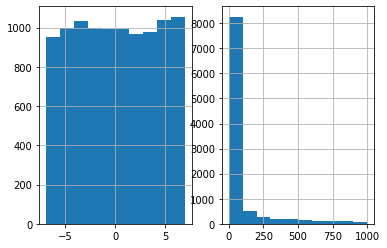

In [66]:
import numpy as np,pandas as pd,matplotlib.pyplot as mpl
from scipy.stats import rv_continuous,kstest
#———————————————————————————————————————
class logUniform_gen(rv_continuous):
    # random numbers log-uniformly distributed between 1 and e
    def _cdf(self,x):
        return np.log(x/self.a)/np.log(self.b/self.a)
def logUniform(a=1,b=np.exp(1)):return logUniform_gen(a=a,b=b,name='logUniform')
#———————————————————————————————————————
a,b,size=1E-3,1E3,10000
vals=logUniform(a=a,b=b).rvs(size=size)
print(kstest(rvs=np.log(vals),cdf='uniform',args=(np.log(a),np.log(b/a)),N=size))
print(pd.Series(vals).describe())
mpl.subplot(121)
pd.Series(np.log(vals)).hist()
mpl.subplot(122)
pd.Series(vals).hist()
mpl.show()

## CHAPTER 10 - Bet Sizing

#### SNIPPET 10.1 FROM PROBABILITIES TO BET SIZE

In [67]:
def getSignal(events,stepSize,prob,pred,numClasses,numThreads,**kargs):
    # get signals from predictions
    if prob.shape[0]==0:return pd.Series()
    #1) generate signals from multinomial classification (one-vs-rest, OvR)
    signal0=(prob-1./numClasses)/(prob*(1.-prob))**.5 # t-value of OvR
    signal0=pred*(2*norm.cdf(signal0)-1) # signal=side*size
    if 'side' in events:signal0*=events.loc[signal0.index,'side'] # meta-labeling
    #2) compute average signal among those concurrently open
    df0=signal0.to_frame('signal').join(events[['t1']],how='left')
    df0=avgActiveSignals(df0,numThreads)
    signal1=discreteSignal(signal0=df0,stepSize=stepSize)
    return signal1

#### SNIPPET 10.2 BETS ARE AVERAGED AS LONG AS THEY ARE STILL ACTIVE

In [69]:
def avgActiveSignals(signals,numThreads):
    # compute the average signal among those active
    #1) time points where signals change (either one starts or one ends)
    tPnts=set(signals['t1'].dropna().values)
    tPnts=tPnts.union(signals.index.values)
    tPnts=list(tPnts);tPnts.sort()
    out=mpPandasObj(mpAvgActiveSignals,('molecule',tPnts),numThreads,signals=signals)
    return out
#———————————————————————————————————————
def mpAvgActiveSignals(signals,molecule):
    '''
    At time loc, average signal among those still active.
    Signal is active if:
        a) issued before or at loc AND
        b) loc before signal's endtime, or endtime is still unknown (NaT).
    '''
    out=pd.Series()
    for loc in molecule:
        df0=(signals.index.values<=loc)&((loc<signals['t1'])|pd.isnull(signals['t1']))
        act=signals[df0].index
        if len(act)>0:out[loc]=signals.loc[act,'signal'].mean()
        else:out[loc]=0 # no signals active at this time
    return out

#### SNIPPET 10.3 SIZE DISCRETIZATION TO PREVENT OVERTRADING

In [70]:
def discreteSignal(signal0,stepSize):
    # discretize signal
    signal1=(signal0/stepSize).round()*stepSize # discretize
    signal1[signal1>1]=1 # cap
    signal1[signal1<-1]=-1 # floor
    return signal1

#### SNIPPET 10.4 DYNAMIC POSITION SIZE AND LIMIT PRICE

In [71]:
def betSize(w,x):
    return x*(w+x**2)**-.5
#———————————————————————————————————————
def getTPos(w,f,mP,maxPos):
    return int(betSize(w,f-mP)*maxPos)
#———————————————————————————————————————
def invPrice(f,w,m):
    return f-m*(w/(1-m**2))**.5
#———————————————————————————————————————
def limitPrice(tPos,pos,f,w,maxPos):
    sgn=(1 if tPos>=pos else -1)
    lP=0
    for j in xrange(abs(pos+sgn),abs(tPos+1)):
        lP+=invPrice(f,w,j/float(maxPos))
    lP/=tPos-pos
    return lP
#———————————————————————————————————————
def getW(x,m):
    # 0<alpha<1
    return x**2*(m**-2–1)
#———————————————————————————————————————
def main():
    pos,maxPos,mP,f,wParams=0,100,100,115,{'divergence':10,'m':.95}
    w=getW(wParams['divergence'],wParams['m']) # calibrate w
    tPos=getTPos(w,f,mP,maxPos) # get tPos
    lP=limitPrice(tPos,pos,f,w,maxPos) # limit price for order
    return
#———————————————————————————————————————
if __name__=='__main__':main()

SyntaxError: invalid character in identifier (<ipython-input-71-085c083900c1>, line 20)

## CHAPTER 13 - Backtesting on Synthetic Data

#### SNIPPET 13.1 PYTHON CODE FOR THE DETERMINATION OF OPTIMAL TRADING RULES

In [72]:
import numpy as np
from random import gauss
from itertools import product
#———————————————————————————————————————
def main():
    rPT=rSLm=np.linspace(0,10,21)
    count=0
    for prod_ in product([10,5,0,-5,-10],[5,10,25,50,100]):
        count+=1
        coeffs={'forecast':prod_[0],'hl':prod_[1],'sigma':1}
        output=batch(coeffs,nIter=1e5,maxHP=100,rPT=rPT,rSLm=rSLm)
    return output

#### SNIPPET 13.2 PYTHON CODE FOR THE DETERMINATION OF OPTIMAL TRADING RULES

In [74]:
def batch(coeffs,nIter=1e5,maxHP=100,rPT=np.linspace(.5,10,20),
    rSLm=np.linspace(.5,10,20),seed=0):
    phi,output1=2**(-1./coeffs['hl']),[]
    for comb_ in product(rPT,rSLm):
        output2=[]
        for iter_ in range(int(nIter)):
            p,hp,count=seed,0,0
            while True:
                p=(1-phi)*coeffs['forecast']+phi*p+coeffs['sigma']*gauss(0,1)
                cP=p-seed;hp+=1
                if cP>comb_[0] or cP<-comb_[1] or hp>maxHP:
                    output2.append(cP)
                    break
        mean,std=np.mean(output2),np.std(output2)
        print(comb_[0],comb_[1],mean,std,mean/std)
        output1.append((comb_[0],comb_[1],mean,std,mean/std))
    return output1

## CHAPTER 14 - Backtest Statistics

#### SNIPPET 14.1 DERIVING THE TIMING OF BETS FROM A SERIES OF TARGET POSITIONS

In [76]:
# A bet takes place between flat positions or position flips
df0=tPos[tPos==0].index
df1=tPos.shift(1);df1=df1[df1!=0].index
bets=df0.intersection(df1) # flattening
df0=tPos.iloc[1:]*tPos.iloc[:-1].values
bets=bets.union(df0[df0<0].index).sort_values() # tPos flips
if tPos.index[-1] not in bets:bets=bets.append(tPos.index[-1:]) # last bet

NameError: name 'tPos' is not defined

#### SNIPPET 14.2 IMPLEMENTATION OF A HOLDING PERIOD ESTIMATOR

In [77]:
def getHoldingPeriod(tPos):
    # Derive avg holding period (in days) using avg entry time pairing algo
    hp,tEntry=pd.DataFrame(columns=['dT','w']),0.
    pDiff,tDiff=tPos.diff(),(tPos.index-tPos.index[0])/np.timedelta64(1,'D')
    for i in xrange(1,tPos.shape[0]):
        if pDiff.iloc[i]*tPos.iloc[i-1]>=0: # increased or unchanged
            if tPos.iloc[i]!=0:
                tEntry=(tEntry*tPos.iloc[i-1]+tDiff[i]*pDiff.iloc[i])/tPos.iloc[i]
        else: # decreased
            if tPos.iloc[i]*tPos.iloc[i-1]<0: # flip
                hp.loc[tPos.index[i],['dT','w']]=(tDiff[i]-tEntry,abs(tPos.iloc[i-1]))
                tEntry=tDiff[i] # reset entry time
            else:
                hp.loc[tPos.index[i],['dT','w']]=(tDiff[i]-tEntry,abs(pDiff.iloc[i]))
    if hp['w'].sum()>0:hp=(hp['dT']*hp['w']).sum()/hp['w'].sum()
    else:hp=np.nan
    return hp

#### SNIPPET 14.3 ALGORITHM FOR DERIVING HHI CONCENTRATION

In [79]:
def getHHI(betRet):
    if betRet.shape[0]<=2:return np.nan
    wght=betRet/betRet.sum()
    hhi=(wght**2).sum()
    hhi=(hhi-betRet.shape[0]**-1)/(1.-betRet.shape[0]**-1)
    return hhi
#————————————————————————————————————————
rHHIPos=getHHI(ret[ret>=0]) # concentration of positive returns per bet
rHHINeg=getHHI(ret[ret<0]) # concentration of negative returns per bet
tHHI=getHHI(ret.groupby(pd.TimeGrouper(freq='M')).count()) # concentr. bets/month

NameError: name 'ret' is not defined

#### SNIPPET 14.4 DERIVING THE SEQUENCE OF DD AND TuW

In [81]:
def computeDD_TuW(series,dollars=False):
    # compute series of drawdowns and the time under water associated with them
    df0=series.to_frame('pnl')
    df0['hwm']=series.expanding().max()
    df1=df0.groupby('hwm').min().reset_index()
    df1.columns=['hwm','min']
    df1.index=df0['hwm'].drop_duplicates(keep='first').index # time of hwm
    df1=df1[df1['hwm']>df1['min']] # hwm followed by a drawdown
    if dollars:dd=df1['hwm']-df1['min']
    else:dd=1-df1['min']/df1['hwm']
    tuw=((df1.index[1:]-df1.index[:-1])/np.timedelta64(1,'Y')).values# in years
    tuw=pd.Series(tuw,index=df1.index[:-1])
    return dd,tuw

## CHAPTER 15 - Understanding Strategy Risk

#### SNIPPET 15.1 TARGETING A SHARPE RATIO AS A FUNCTION OF THE NUMBER OF BETS

In [84]:
out,p=[],.55
for i in range(1000000):
    rnd=np.random.binomial(n=1,p=p)
    x=(1 if rnd==1 else -1)
    out.append(x)
print(np.mean(out),np.std(out),np.mean(out)/np.std(out))

0.100526 0.9949344316707509 0.10103781395040373


#### SNIPPET 15.2 USING THE SymPy LIBRARY FOR SYMBOLIC OPERATIONS

In [85]:
>>> from sympy import *
>>> init_printing(use_unicode=False,wrap_line=False,no_global=True)
>>> p,u,d=symbols('p u d')
>>> m2=p*u**2+(1-p)*d**2
>>> m1=p*u+(1-p)*d
>>> v=m2-m1**2
>>> factor(v)

#### SNIPPET 15.3 COMPUTING THE IMPLIED PRECISION

In [86]:
def binHR(sl,pt,freq,tSR):
    '''
    Given a trading rule characterized by the parameters {sl,pt,freq},
    what's the min precision p required to achieve a Sharpe ratio tSR?
    1) Inputs
    sl: stop loss threshold
    pt: profit taking threshold
    freq: number of bets per year
        tSR: target annual Sharpe ratio
    2) Output
    p: the min precision rate p required to achieve tSR
    '''
    a=(freq+tSR**2)*(pt-sl)**2
    b=(2*freq*sl-tSR**2*(pt-sl))*(pt-sl)
    c=freq*sl**2
    p=(-b+(b**2–4*a*c)**.5)/(2.*a)
    return p

SyntaxError: invalid character in identifier (<ipython-input-86-57b8a36c83e9>, line 16)

#### SNIPPET 15.4 COMPUTING THE IMPLIED BETTING FREQUENCY

In [87]:
def binFreq(sl,pt,p,tSR):
    '''
    Given a trading rule characterized by the parameters {sl,pt,freq},
    what's the number of bets/year needed to achieve a Sharpe ratio
    tSR with precision rate p?
    Note: Equation with radicals, check for extraneous solution.
    1) Inputs
    sl: stop loss threshold
    pt: profit taking threshold
    p: precision rate p
    tSR: target annual Sharpe ratio
    2) Output
    freq: number of bets per year needed
    '''
    freq=(tSR*(pt-sl))**2*p*(1-p)/((pt-sl)*p+sl)**2 # possible extraneous
    if not np.isclose(binSR(sl,pt,freq,p),tSR):return
    return freq

#### SNIPPET 15.5 CALCULATING THE STRATEGY RISK IN PRACTICE

In [90]:
import numpy as np,scipy.stats as ss
#———————————————————————————————————————
def mixGaussians(mu1,mu2,sigma1,sigma2,prob1,nObs):
    # Random draws from a mixture of gaussians
    ret1=np.random.normal(mu1,sigma1,size=int(nObs*prob1))
    ret2=np.random.normal(mu2,sigma2,size=int(nObs)-ret1.shape[0])
    ret=np.append(ret1,ret2,axis=0)
    np.random.shuffle(ret)
    return ret
#———————————————————————————————————————
def probFailure(ret,freq,tSR):
    # Derive probability that strategy may fail
    rPos,rNeg=ret[ret>0].mean(),ret[ret<=0].mean()
    p=ret[ret>0].shape[0]/float(ret.shape[0])
    thresP=binHR(rNeg,rPos,freq,tSR)
    risk=ss.norm.cdf(thresP,p,p*(1-p)) # approximation to bootstrap
    return risk
#———————————————————————————————————————
def main():
    #1) Parameters
    mu1,mu2,sigma1,sigma2,prob1,nObs=.05,-.1,.05,.1,.75,2600
    tSR,freq=2.,260
    #2) Generate sample from mixture
    ret=mixGaussians(mu1,mu2,sigma1,sigma2,prob1,nObs)
    #3) Compute prob failure
    probF=probFailure(ret,freq,tSR)
    print('Prob strategy will fail',probF)
    return
#———————————————————————————————————————
if __name__=='__main__':main()

NameError: name 'binHR' is not defined

## CHAPTER 16 - Machine Learning Asset Allocation

#### SNIPPET 16.1 TREE CLUSTERING USING SCIPY FUNCTIONALITY

In [91]:
import scipy.cluster.hierarchy as sch
import numpy as np
import pandas as pd
cov,corr=x.cov(),x.corr()
dist=((1-corr)/2.)**.5 # distance matrix
link=sch.linkage(dist,'single') # linkage matrix

AttributeError: 'int' object has no attribute 'cov'

#### SNIPPET 16.2 QUASI-DIAGONALIZATION

In [92]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int)
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3] # number of original items
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space
        df0=sortIx[sortIx>=numItems] # find clusters
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0) # item 2
        sortIx=sortIx.sort_index() # re-sort
        sortIx.index=range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

#### SNIPPET 16.3 RECURSIVE BISECTION

In [93]:
def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)/2),\
            (len(i)/2,len(i))) if len(i)>1] # bi-section
    for i in xrange(0,len(cItems),2): # parse in pairs
        cItems0=cItems[i] # cluster 1
        cItems1=cItems[i+1] # cluster 2
        cVar0=getClusterVar(cov,cItems0)
        cVar1=getClusterVar(cov,cItems1)
        alpha=1-cVar0/(cVar0+cVar1)
        w[cItems0]*=alpha # weight 1
        w[cItems1]*=1-alpha # weight 2
    return w

#### SNIPPET 16.4 FULL IMPLEMENTATION OF THE HRP ALGORITHM

In [ ]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd
#———————————————————————————————————————
def getIVP(cov,**kargs):
# Compute the inverse-variance portfolio
ivp=1./np.diag(cov)
ivp/=ivp.sum()
return ivp
#———————————————————————————————————————
def getClusterVar(cov,cItems):
# Compute variance per cluster
cov_=cov.loc[cItems,cItems] # matrix slice
w_=getIVP(cov_).reshape(-1,1)
cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
return cVar
#———————————————————————————————————————
def getQuasiDiag(link):
# Sort clustered items by distance
link=link.astype(int)
sortIx=pd.Series([link[-1,0],link[-1,1]])
numItems=link[-1,3] # number of original items
while sortIx.max()>=numItems:
sortIx.index=range(0,sortIx.shape[0]*2,2) # make space
df0=sortIx[sortIx>=numItems] # find clusters
i=df0.index;j=df0.values-numItems
sortIx[i]=link[j,0] # item 1
df0=pd.Series(link[j,1],index=i+1)
sortIx=sortIx.append(df0) # item 2
sortIx=sortIx.sort_index() # re-sort
sortIx.index=range(sortIx.shape[0]) # re-index
return sortIx.tolist()
#———————————————————————————————————————
def getRecBipart(cov,sortIx):
# Compute HRP alloc
w=pd.Series(1,index=sortIx)
cItems=[sortIx] # initialize all items in one cluster
while len(cItems)>0:
cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)/2), \
(len(i)/2,len(i))) if len(i)>1] # bi-section
for i in xrange(0,len(cItems),2): # parse in pairs
cItems0=cItems[i] # cluster 1
cItems1=cItems[i+1] # cluster 2
cVar0=getClusterVar(cov,cItems0)
cVar1=getClusterVar(cov,cItems1)
alpha=1-cVar0/(cVar0+cVar1)
w[cItems0]*=alpha # weight 1
w[cItems1]*=1-alpha # weight 2
return w
#———————————————————————————————————————
def correlDist(corr):
# A distance matrix based on correlation, where 0<=d[i,j]<=1
# This is a proper distance metric
dist=((1-corr)/2.)**.5 # distance matrix
return dist
#———————————————————————————————————————
def plotCorrMatrix(path,corr,labels=None):
# Heatmap of the correlation matrix
if labels is None:labels=[]
mpl.pcolor(corr)
mpl.colorbar()
mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
mpl.savefig(path)
mpl.clf();mpl.close() # reset pylab
return
#———————————————————————————————————————
def generateData(nObs,size0,size1,sigma1):
# Time series of correlated variables
#1) generating some uncorrelated data
np.random.seed(seed=12345);random.seed(12345)
x=np.random.normal(0,1,size=(nObs,size0)) # each row is a variable
#2) creating correlation between the variables
cols=[random.randint(0,size0–1) for i in xrange(size1)]
y=x[:,cols]+np.random.normal(0,sigma1,size=(nObs,len(cols)))
x=np.append(x,y,axis=1)
x=pd.DataFrame(x,columns=range(1,x.shape[1]+1))
return x,cols
#———————————————————————————————————————
def main():
#1) Generate correlated data
nObs,size0,size1,sigma1=10000,5,5,.25
x,cols=generateData(nObs,size0,size1,sigma1)
print [(j+1,size0+i) for i,j in enumerate(cols,1)]
cov,corr=x.cov(),x.corr()
#2) compute and plot correl matrix
plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
#3) cluster
dist=correlDist(corr)
link=sch.linkage(dist,'single')
sortIx=getQuasiDiag(link)
sortIx=corr.index[sortIx].tolist() # recover labels
df0=corr.loc[sortIx,sortIx] # reorder
plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
#4) Capital allocation
hrp=getRecBipart(cov,sortIx)
print hrp
return
#———————————————————————————————————————
if __name__=='__main__':main()

#### SNIPPET 16.5 MONTE CARLO EXPERIMENT ON HRP OUT-OF-SAMPLE PERFORMANCE

In [ ]:
(...)

## CHAPTER 17 - Structural Breaks
#### SNIPPET 17.1 SADF’S INNER LOOP

In [94]:
def get_bsadf(logP,minSL,constant,lags):
    y,x=getYX(logP,constant=constant,lags=lags)
    startPoints,bsadf,allADF=range(0,y.shape[0]+lags-minSL+1),None,[]
    for start in startPoints:
        y_,x_=y[start:],x[start:]
        bMean_,bStd_=getBetas(y_,x_)
        bMean_,bStd_=bMean_[0,0],bStd_[0,0]**.5
        allADF.append(bMean_/bStd_)
        if allADF[-1]>bsadf:bsadf=allADF[-1]
    out={'Time':logP.index[-1],'gsadf':bsadf}
    return out

#### SNIPPET 17.2 PREPARING THE DATASETS

In [95]:
def getYX(series,constant,lags):
    series_=series.diff().dropna()
    x=lagDF(series_,lags).dropna()
    x.iloc[:,0]=series.values[-x.shape[0]-1:-1,0] # lagged level
    y=series_.iloc[-x.shape[0]:].values
    if constant!='nc':
        x=np.append(x,np.ones((x.shape[0],1)),axis=1)
        if constant[:2]=='ct':
            trend=np.arange(x.shape[0]).reshape(-1,1)
            x=np.append(x,trend,axis=1)
        if constant=='ctt':
            x=np.append(x,trend**2,axis=1)
    return y,x

#### SNIPPET 17.3 APPLY LAGS TO DATAFRAME

In [96]:
def lagDF(df0,lags):
    df1=pd.DataFrame()
    if isinstance(lags,int):lags=range(lags+1)
    else:lags=[int(lag) for lag in lags]
    for lag in lags:
        df_=df0.shift(lag).copy(deep=True)
        df_.columns=[str(i)+'_'+str(lag) for i in df_.columns]
        df1=df1.join(df_,how='outer')
    return df1

#### SNIPPET 17.4 FITTING THE ADF SPECIFICATION

In [97]:
def getBetas(y,x):
    xy=np.dot(x.T,y)
    xx=np.dot(x.T,x)
    xxinv=np.linalg.inv(xx)
    bMean=np.dot(xxinv,xy)
    err=y-np.dot(x,bMean)
    bVar=np.dot(err.T,err)/(x.shape[0]-x.shape[1])*xxinv
    return bMean,bVar

## CHAPTER 18 - Entropy Features
#### SNIPPET 18.1 PLUG-IN ENTROPY ESTIMATOR

In [98]:
import time,numpy as np
#———————————————————————————————————————
def plugIn(msg,w):
    # Compute plug-in (ML) entropy rate
    pmf=pmf1(msg,w)
    out=-sum([pmf[i]*np.log2(pmf[i]) for i in pmf])/w
    return out,pmf
#———————————————————————————————————————
def pmf1(msg,w):
    # Compute the prob mass function for a one-dim discrete rv
    # len(msg)-w occurrences
    lib={}
    if not isinstance(msg,str):msg=''.join(map(str,msg))
    for i in xrange(w,len(msg)):
        msg_=msg[i-w:i]
        if msg_ not in lib:lib[msg_]=[i-w]
        else:lib[msg_]=lib[msg_]+[i-w]
    pmf=float(len(msg)-w)
    pmf={i:len(lib[i])/pmf for i in lib}
    return pmf

#### SNIPPET 18.2 A LIBRARY BUILT USING THE LZ ALGORITHM

In [100]:
def lempelZiv_lib(msg):
    i,lib=1,[msg[0]]
    while i<len(msg):
        for j in xrange(i,len(msg)):
            msg_=msg[i:j+1]
            if msg_ not in lib:
                lib.append(msg_)
                break
    i=j+1
    return lib

#### SNIPPET 18.3 FUNCTION THAT COMPUTES THE LENGTH OF THE LONGEST MATCH

In [101]:
def matchLength(msg,i,n):
    # Maximum matched length+1, with overlap.
    # i>=n & len(msg)>=i+n
    subS=''
    for l in xrange(n):
        msg1=msg[i:i+l+1]
        for j in xrange(i-n,i):
            msg0=msg[j:j+l+1]
            if msg1==msg0:
                subS=msg1
                break # search for higher l.
    return len(subS)+1,subS # matched length + 1

#### SNIPPET 18.4 IMPLEMENTATION OF ALGORITHMS DISCUSSED IN GAO ET AL. [2008]

In [104]:
def konto(msg,window=None):
    '''
    * Kontoyiannis’ LZ entropy estimate, 2013 version (centered window).
    * Inverse of the avg length of the shortest non-redundant substring.
    * If non-redundant substrings are short, the text is highly entropic.
    * window==None for expanding window, in which case len(msg)%2==0
    * If the end of msg is more relevant, try konto(msg[::-1])
    '''
    out={'num':0,'sum':0,'subS':[]}
    if not isinstance(msg,str):msg=''.join(map(str,msg))
    if window is None:
        points=range(1,len(msg)/2+1)
    else:
        window=min(window,len(msg)/2)
        points=xrange(window,len(msg)-window+1)
    for i in points:
        if window is None:
            l,msg_=matchLength(msg,i,i)
            out['sum']+=np.log2(i+1)/l # to avoid Doeblin condition
        else:
            l,msg_=matchLength(msg,i,window)
            out['sum']+=np.log2(window+1)/l # to avoid Doeblin condition
        out['subS'].append(msg_)
        out['num']+=1
    out['h']=out['sum']/out['num']
    out['r']=1-out['h']/np.log2(len(msg)) # redundancy, 0<=r<=1
    return out
#———————————————————————————————————————
if __name__=='__main__':
    msg='101010'
    print(konto(msg*2))
    print(konto(msg+msg[::-1]))

TypeError: 'float' object cannot be interpreted as an integer

## CHAPTER 19 - Microstructural Features
#### SNIPPET 19.1 IMPLEMENTATION OF THE CORWIN-SCHULTZ ALGORITHM

In [105]:
def getBeta(series,sl):
    hl=series[['High','Low']].values
    hl=np.log(hl[:,0]/hl[:,1])**2
    hl=pd.Series(hl,index=series.index)
    beta=pd.stats.moments.rolling_sum(hl,window=2)
    beta=pd.stats.moments.rolling_mean(beta,window=sl)
    return beta.dropna()
#———————————————————————————————————————-
def getGamma(series):
    h2=pd.stats.moments.rolling_max(series['High'],window=2)
    l2=pd.stats.moments.rolling_min(series['Low'],window=2)
    gamma=np.log(h2.values/l2.values)**2
    gamma=pd.Series(gamma,index=h2.index)
    return gamma.dropna()
#———————————————————————————————————————-
def getAlpha(beta,gamma):
    den=3–2*2**.5
    alpha=(2**.5–1)*(beta**.5)/den
    alpha-=(gamma/den)**.5
    alpha[alpha<0]=0 # set negative alphas to 0 (see p.727 of paper)
    return alpha.dropna()
#———————————————————————————————————————-
def corwinSchultz(series,sl=1):
    # Note: S<0 iif alpha<0
    beta=getBeta(series,sl)
    gamma=getGamma(series)
    alpha=getAlpha(beta,gamma)
    spread=2*(np.exp(alpha)-1)/(1+np.exp(alpha))
    startTime=pd.Series(series.index[0:spread.shape[0]],index=spread.index)
    spread=pd.concat([spread,startTime],axis=1)
    spread.columns=['Spread','Start_Time'] # 1st loc used to compute beta
    return spread

SyntaxError: invalid character in identifier (<ipython-input-105-6c32cf2e01c3>, line 17)

#### SNIPPET 19.2 ESTIMATING VOLATILITY FOR HIGH-LOW PRICES

In [106]:
def getSigma(beta,gamma):
    k2=(8/np.pi)**.5
    den=3–2*2**.5
    sigma=(2**-.5–1)*beta**.5/(k2*den)
    sigma+=(gamma/(k2**2*den))**.5
    sigma[sigma<0]=0
    return sigma

SyntaxError: invalid character in identifier (<ipython-input-106-fbbf1b8029c7>, line 3)

## CHAPTER 20 - Multiprocessing and Vectorization
#### SNIPPET 20.1 UN-VECTORIZED CARTESIAN PRODUCT

In [108]:
# Cartesian product of dictionary of lists
dict0={'a':['1','2'],'b':['+','*'],'c':['!','@']}
for a in dict0['a']:
    for b in dict0['b']:
        for c in dict0['c']:
            print({'a':a,'b':b,'c':c})

{'a': '1', 'b': '+', 'c': '!'}
{'a': '1', 'b': '+', 'c': '@'}
{'a': '1', 'b': '*', 'c': '!'}
{'a': '1', 'b': '*', 'c': '@'}
{'a': '2', 'b': '+', 'c': '!'}
{'a': '2', 'b': '+', 'c': '@'}
{'a': '2', 'b': '*', 'c': '!'}
{'a': '2', 'b': '*', 'c': '@'}


#### SNIPPET 20.2 VECTORIZED CARTESIAN PRODUCT

In [112]:
# Cartesian product of dictionary of lists
from itertools import izip,product
dict0={'a':['1','2'],'b':['+','*'],'c':['!','@']}
jobs=(dict(izip(dict0,i)) for i in product(*dict0.values()))
for i in jobs: print(i)

ImportError: cannot import name 'izip' from 'itertools' (unknown location)

#### SNIPPET 20.3 SINGLE-THREAD IMPLEMENTATION OF A ONE-TOUCH DOUBLE BARRIER

In [115]:
import numpy as np
#———————————————————————————————————————
def main0():
    # Path dependency: Sequential implementation
    r=np.random.normal(0,.01,size=(1000,10000))
    t=barrierTouch(r)
    return
#———————————————————————————————————————
def barrierTouch(r,width=.5):
    # find the index of the earliest barrier touch
    t,p={},np.log((1+r).cumprod(axis=0))
    for j in range(r.shape[1]): # go through columns
        for i in range(r.shape[0]): # go through rows
            if p[i,j]>=width or p[i,j]<=-width:
                t[j]=i
                continue
    return t
#———————————————————————————————————————
if __name__=='__main__':
    import timeit
    print(min(timeit.Timer('main0()',setup='from __main__ import main0').repeat(5,10)))

49.66141710000011


#### SNIPPET 20.4 MULTIPROCESSING IMPLEMENTATION OF A ONE-TOUCH DOUBLE BARRIER

In [ ]:
import numpy as np
import multiprocessing as mp
#———————————————————————————————————————
def main1():
    # Path dependency: Multi-threaded implementation
    r,numThreads=np.random.normal(0,.01,size=(1000,10000)),24
    parts=np.linspace(0,r.shape[0],min(numThreads,r.shape[0])+1)
    parts,jobs=np.ceil(parts).astype(int),[]
    for i in range(1,len(parts)):
        jobs.append(r[:,parts[i-1]:parts[i]]) # parallel jobs
    pool,out=mp.Pool(processes=numThreads),[]
    outputs=pool.imap_unordered(barrierTouch,jobs)
    for out_ in outputs:out.append(out_) # asynchronous response
    pool.close();pool.join()
    return
#———————————————————————————————————————
if __name__=='__main__':
    import timeit
    print(min(timeit.Timer('main1()',setup='from __main__ import main1').repeat(5,10)))

#### SNIPPET 20.5 THE linParts FUNCTION

In [ ]:
import numpy as np
#———————————————————————————————————————
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

#### SNIPPET 20.6 THE nestedParts FUNCTION

In [ ]:
def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in xrange(numThreads_):
        part=1 + 4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are the heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts

#### SNIPPET 20.7 THE mpPandasObj, USED AT VARIOUS POINTS IN THE BOOK

In [ ]:
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a DataFrame or Series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kargs: any other argument needed by func
    Example: df1=mpPandasObj(func,(’molecule’,df0.index),24,**kargs)
    '''
    import pandas as pd
    if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    jobs=[] for i in xrange(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else:out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

#### SNIPPET 20.8 SINGLE-THREAD EXECUTION, FOR DEBUGGING

In [ ]:
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out

#### SNIPPET 20.9 EXAMPLE OF ASYNCHRONOUS CALL TO PYTHON’S MULTIPROCESSING LIBRARY

In [ ]:
import multiprocessing as mp
#———————————————————————————————————————
def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs,(time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
    str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return
#———————————————————————————————————————
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a ’func’ callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asynchronous output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

#### SNIPPET 20.10 PASSING THE JOB (MOLECULE) TO THE CALLBACK FUNCTION

In [ ]:
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs[’func’]
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

#### SNIPPET 20.11 PLACE THIS CODE AT THE BEGINNING OF YOUR ENGINE

In [ ]:
def _pickle_method(method):
    func_name=method.im_func.__name__
    obj=method.im_self
    cls=method.im_class
    return _unpickle_method,(func_name,obj,cls)
#———————————————————————————————————————
def _unpickle_method(func_name,obj,cls):
    for cls in cls.mro():
        try:func=cls.__dict__[func_name]
        except KeyError:pass
        else:break
    return func.__get__(obj,cls)
#———————————————————————————————————————
import copy_reg,types,multiprocessing as mp
copy_reg.pickle(types.MethodType,_pickle_method,_unpickle_method)

#### SNIPPET 20.12 ENHANCING processJobs TO PERFORM ON-THE-FLY OUTPUT REDUCTION

In [ ]:
def processJobsRedux(jobs,task=None,numThreads=24,redux=None,reduxArgs={},
                    reduxInPlace=False):
    '''
    Run in parallel
    jobs must contain a ’func’ callback, for expandCall
    redux prevents wasting memory by reducing output on the fly
    '''
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    imap,out,time0=pool.imap_unordered(expandCall,jobs),None,time.time()
    # Process asynchronous output, report progress
    for i,out_ in enumerate(imap,1):
        if out is None:
            if redux is None:out,redux,reduxInPlace=[out_],list.append,True
            else:out=copy.deepcopy(out_)
        else:
            if reduxInPlace:redux(out,out_,**reduxArgs)
            else:out=redux(out,out_,**reduxArgs)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    if isinstance(out,(pd.Series,pd.DataFrame)):out=out.sort_index()
    return out

#### SNIPPET 20.13 ENHANCING mpPandasObj TO PERFORM ON-THE-FLY OUTPUT REDUCTION

In [ ]:
def mpJobList(func,argList,numThreads=24,mpBatches=1,linMols=True,redux=None,
            reduxArgs={},reduxInPlace=False,**kargs):
    if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    jobs=[]
    for i in xrange(1,len(parts)):
        job={argList[0]:argList[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    out=processJobsRedux(jobs,redux=redux,reduxArgs=reduxArgs,
                    reduxInPlace=reduxInPlace,numThreads=numThreads)
    return out

#### SNIPPET 20.14 PRINCIPAL COMPONENTS FOR A SUBSET OF THE COLUMNS

In [ ]:
pcs=mpJobList(getPCs,('molecules',fileNames),numThreads=24,mpBatches=1,
    path=path,eVec=eVec,redux=pd.DataFrame.add)
#——————————————————————————————————————
def getPCs(path,molecules,eVec):
    # get principal components by loading one file at a time
    pcs=None
    for i in molecules:
        df0=pd.read_csv(path+i,index_col=0,parse_dates=True)
        if pcs is None:pcs=np.dot(df0.values,eVec.loc[df0.columns].values)
        else:pcs+=np.dot(df0.values,eVec.loc[df0.columns].values)
    pcs=pd.DataFrame(pcs,index=df0.index,columns=eVec.columns)
    return pcs

## CHAPTER 21 - Brute Force and Quantum Computers
#### SNIPPET 21.1 PARTITIONS OF k OBJECTS INTO n SLOTS

In [ ]:
from itertools import combinations_with_replacement
#———————————————————————————————————————
def pigeonHole(k,n):
    # Pigeonhole problem (organize k objects in n slots)
    for j in combinations_with_replacement(xrange(n),k):
        r=[0]*n
        for i in j:
            r[i]+=1
        yield r

#### SNIPPET 21.2 SET 𝛀 OF ALL VECTORS ASSOCIATED WITH ALL PARTITIONS

In [ ]:
import numpy as np
from itertools import product
#———————————————————————————————————————
def getAllWeights(k,n):
    #1) Generate partitions
    parts,w=pigeonHole(k,n),None
    #2) Go through partitions
    for part_ in parts:
        w_=np.array(part_)/float(k) # abs(weight) vector
        for prod_ in product([-1,1],repeat=n): # add sign
            w_signed_=(w_*prod_).reshape(-1,1)
            if w is None:w=w_signed_.copy()
            else:w=np.append(w,w_signed_,axis=1)
    return w

#### SNIPPET 21.3 EVALUATING ALL TRAJECTORIES

In [ ]:
import numpy as np
from itertools import product
#———————————————————————————————————————
def evalTCosts(w,params):
    # Compute t-costs of a particular trajectory
    tcost=np.zeros(w.shape[1])
    w_=np.zeros(shape=w.shape[0])
    for i in range(tcost.shape[0]):
        c_=params[i]['c']
        tcost[i]=(c_*abs(w[:,i]-w_)**.5).sum()
        w_=w[:,i].copy()
    return tcost
#———————————————————————————————————————
def evalSR(params,w,tcost):
    # Evaluate SR over multiple horizons
    mean,cov=0,0
    for h in range(w.shape[1]):
        params_=params[h]
        mean+=np.dot(w[:,h].T,params_['mean'])[0]-tcost[h]
        cov+=np.dot(w[:,h].T,np.dot(params_['cov'],w[:,h]))
    sr=mean/cov**.5
    return sr
#———————————————————————————————————————
def dynOptPort(params,k=None):
    # Dynamic optimal portfolio
    #1) Generate partitions
    if k is None:k=params[0]['mean'].shape[0]
    n=params[0]['mean'].shape[0]
    w_all,sr=getAllWeights(k,n),None
    #2) Generate trajectories as cartesian products
    for prod_ in product(w_all.T,repeat=len(params)):
        w_=np.array(prod_).T # concatenate product into a trajectory
        tcost_=evalTCosts(w_,params)
        sr_=evalSR(params,w_,tcost_) # evaluate trajectory
        if sr is None or sr<sr_: # store trajectory if better
            sr,w=sr_,w_.copy()
    return w

#### SNIPPET 21.4 PRODUCE A RANDOM MATRIX OF A GIVEN RANK

In [ ]:
import numpy as np
#———————————————————————————————————————
def rndMatWithRank(nSamples,nCols,rank,sigma=0,homNoise=True):
    # Produce random matrix X with given rank
    rng=np.random.RandomState()
    U,_,_=np.linalg.svd(rng.randn(nCols,nCols))
    x=np.dot(rng.randn(nSamples,rank),U[:,:rank].T)
    if homNoise:
        x+=sigma*rng.randn(nSamples,nCols) # Adding homoscedastic noise
    else:
        sigmas=sigma*(rng.rand(nCols)+.5) # Adding heteroscedastic noise
        x+=rng.randn(nSamples,nCols)*sigmas
    return x

#### SNIPPET 21.5 GENERATE THE PROBLEM’S PARAMETERS

In [ ]:
import numpy as np
#———————————————————————————————————————
def genMean(size):
    # Generate a random vector of means
    rMean=np.random.normal(size=(size,1))
    return rMean
#———————————————————————————————————————
    #1) Parameters
    size,horizon=3,2
    params=[]
    for h in range(horizon):
        x=rndMatWithRank(1000,3,3,0.)
        mean_,cov_=genMean(size),np.cov(x,rowvar=False)
        c_=np.random.uniform(size=cov_.shape[0])*np.diag(cov_)**.5
        params.append({'mean':mean_,'cov':cov_,'c':c_})

#### SNIPPET 21.6 COMPUTE AND EVALUATE THE STATIC SOLUTION

In [ ]:
import numpy as np
#———————————————————————————————————————
def statOptPortf(cov,a):
    # Static optimal porftolio
    # Solution to the "unconstrained" portfolio optimization problem
    cov_inv=np.linalg.inv(cov)
    w=np.dot(cov_inv,a)
    w/=np.dot(np.dot(a.T,cov_inv),a) # np.dot(w.T,a)==1
    w/=abs(w).sum() # re-scale for full investment
    return w
#———————————————————————————————————————
#2) Static optimal portfolios
w_stat=None
for params_ in params:
    w_=statOptPortf(cov=params_['cov'],a=params_['mean'])
    if w_stat is None:w_stat=w_.copy()
    else:w_stat=np.append(w_stat,w_,axis=1)
tcost_stat=evalTCosts(w_stat,params)
sr_stat=evalSR(params,w_stat,tcost_stat)
print 'static SR:',sr_stat

#### SNIPPET 21.7 COMPUTE AND EVALUATE THE DYNAMIC SOLUTION

In [ ]:
import numpy as np
#———————————————————————————————————————
#3) Dynamic optimal portfolios
w_dyn=dynOptPort(params)
tcost_dyn=evalTCosts(w_dyn,params)
sr_dyn=evalSR(params,w_dyn,tcost_dyn)
print 'dynamic SR:',sr_dyn